# Parse

In [ ]:
#| default_exp parse

In [ ]:
#| hide

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
#| export

from dreamai_pdf.core import *
from dreamai_pdf.imports import *

In [ ]:
#| export

def col_clusters(data, data2=None, n_cols=3):
    n_cols = int(n_cols)
    kmeans = KMeans(n_clusters=n_cols, algorithm='elkan', random_state=42).fit(np.reshape(data,(-1,1)))
    idx = np.argsort(kmeans.cluster_centers_.sum(axis=1)).tolist()
    cols = defaultdict(list)
    if data2 is None: data2 = data
    for i,c in enumerate(kmeans.labels_):
        cols[idx.index(c)].append(data2[i])
    return cols

class ColumnCounter(KElbowVisualizer):
    def draw(self):
        pass

def get_n_cols(data, min_c=2, max_c=10, max_n_cols=3):
    model = KMeans(algorithm='elkan', random_state=42)
    visualizer = ColumnCounter(model, k=(min_c, max_c), metric='silhouette')
    visualizer.fit(np.reshape(data,(-1,1)))
    # print(np.reshape(data,(-1,1)))
    if visualizer.elbow_value_ is None:
        return max_n_cols
    return min(visualizer.elbow_value_, max_n_cols)

def pdf_to_cols(data_path, model=None, max_n_cols=3, cols_list=[2,1]):
    pdfs = resolve_data_path(data_path)
    cols_dict = {}
    for file in pdfs:
        if Path(file).suffix == '.pdf':
            try:
                if model is not None:
                    cols_list = pred_cols(file, model)
                with pdfplumber.open(file) as pdf:
                    pdf_pages = pdf.pages
                    cols_list = cols_list + [None]*(len(pdf_pages)-len(cols_list))
                    pdf_cols = []
                    for page, n_cols in zip(pdf_pages, cols_list):
                        words = page.extract_words(x_tolerance=5)
                        if len(words) == 0:
                            # raise Exception(f'\nCould not extract words from pdf: {str(file)}\nMaybe try extracting tables?')
                            print(f'\nCould not extract words from pdf: {str(file)}. Maybe try extracting tables?')
                            continue
                        word_x = [w['x0'] for w in words]
                        if n_cols is None:
                            try:
                                n_cols = get_n_cols(word_x, max_n_cols=max_n_cols)
                            except:
                                print(f'\nCould not find ideal number of columns for pdf: {str(file)}. Setting to 1.')
                                n_cols = 1
                        # if n_cols == 0:
                            # print(file)
                        cols = col_clusters(word_x, words, n_cols=n_cols)
                        cols = sort_dict({k:sorted(v, key=lambda x: x['top']) for k,v in cols.items()})
                        for k,v in cols.items():
                            paras = []
                            avg_gap = np.mean([w['top']-v[i-1]['top'] for i,w in enumerate(v) if i>0])
                            for i,w in enumerate(v):
                                txt = w['text']
                                if i==0:
                                    paras.append(txt)
                                else:
                                    if w['top']-v[i-1]['bottom'] >= avg_gap:
                                        paras.append(txt)
                                    else:
                                        paras[-1]+=' '+txt.strip()
                            paras = combine_lines(paras)                
                            cols[k] = paras
                        pdf_cols.append(cols)
                    cols = defaultdict(list)
                    for c in pdf_cols:
                        for k,v in c.items():
                            cols[k]+=v
                    cols = sort_dict(cols)
                    cols_dict[str(file)] = cols
            except:
                continue
    return cols_dict

def pdf_cols_to_text(pdf_cols):
    return flatten_list([dict_values(d) for d in dict_values(pdf_cols)])

def pdf_to_text(data_path, model=None, max_n_cols=3, cols_list=[2,1]):
    pdf_cols = pdf_to_cols(data_path, model=model, max_n_cols=max_n_cols, cols_list=cols_list)
    return pdf_cols_to_text(pdf_cols)

class HeadModel(nn.Module):
    def __init__(self, pool, linear):
        super().__init__()
        # store_attr(self, 'pool,linear')
        self.pool = pool
        self.linear = linear
    def forward(self, x, meta=None):
        if meta is None:
            return self.linear(self.pool(x))  
        return self.linear(torch.cat([self.pool(x), meta], dim=1))

class LinBnDrop(nn.Sequential):
    "Module grouping `BatchNorm1d`, `Dropout` and `Linear` layers"
    def __init__(self, n_in, n_out, bn=True, p=0., act=None, lin_first=False):
        layers = [nn.BatchNorm1d(n_out if lin_first else n_in)] if bn else []
        if p != 0: layers.append(nn.Dropout(p))
        lin = [nn.Linear(n_in, n_out, bias=not bn)]
        if act is not None: lin.append(act)
        layers = lin+layers if lin_first else layers+lin
        super().__init__(*layers)


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`"
    def __init__(self, size=None):
        super().__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

def create_head(nf, n_out, lin_ftrs=None, ps=0.5, concat_pool=True,
                bn_final=False, lin_first=False, y_range=None, actv=None,
                relu_fn=nn.ReLU(inplace=True), trial=None, num_lin_ftrs=None, n_lin_ftrs=None, trial_num_lin_ftrs=[1,3],
                trial_n_lin_ftrs=[256,512,1024]):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    if trial is not None:
        lin_ftrs = [nf]
        num_lin_ftrs = trial.suggest_int("num_lin_ftrs",
                                         trial_num_lin_ftrs[0],
                                         trial_num_lin_ftrs[1])
        for i in range(num_lin_ftrs):
            n_lin_ftrs = trial.suggest_categorical(f"n_lin_ftrs_{i}", trial_n_lin_ftrs)
            # n_lin_ftrs = trial.suggest_categorical(f"n_lin_ftrs_{i}", [1024,1224,1424,1624,1824,2000])
            lin_ftrs.append(n_lin_ftrs)
        lin_ftrs.append(n_out)
    elif num_lin_ftrs is not None and n_lin_ftrs is not None:
        lin_ftrs = [nf]
        for i in range(num_lin_ftrs):
            lin_ftrs.append(n_lin_ftrs[i])
        lin_ftrs.append(n_out)
    else:
        lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = [ps]
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [relu_fn] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    pool_layers = nn.Sequential(*[pool, Flatten()])
    layers = []
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if actv is not None:
        layers.append(actv)
    # return layers
    layers = nn.Sequential(*layers)
    return HeadModel(pool=pool_layers, linear=layers)

# Initialise the resnet 34 model
def create_model(num_classes=4, lin_ftrs=None, ps=0.5, concat_pool=True, bn_final=False, lin_first=False, actv=None,
                relu_fn=nn.ReLU(inplace=True), trial=None, num_lin_ftrs=None, n_lin_ftrs=None, trial_num_lin_ftrs=[1,3],
                trial_n_lin_ftrs=[256,512,1024]):
        body = nn.Sequential(*list(models.get_model("resnet34",weights="DEFAULT").children())[:-2])
        head_layers = create_head(1024, num_classes, lin_ftrs, ps, concat_pool, bn_final=False, lin_first=False, actv=None,
                relu_fn=nn.ReLU(inplace=True), trial=None, num_lin_ftrs=None, n_lin_ftrs=None, trial_num_lin_ftrs=[1,3],
                trial_n_lin_ftrs=[256,512,1024])
        return nn.Sequential(body,head_layers)
    
def load_cols_model(path, device='cuda'):
    net = create_model( num_classes=3, lin_ftrs=[512,128,64], ps=0.5)
    checkpoint = torch.load(path, map_location=torch.device(device))
    net.load_state_dict(checkpoint, strict=True)
    return net.eval()

def pdf_to_batch(pdf):
    return torch.stack([TF.to_tensor(img) for img in color_fill_pdf_text(pdf)])

def pred_cols(pdf, model, classes=[1,2,3], device='cuda'):
    model = model.eval().to(device)
    batch = pdf_to_batch(pdf)
    batch = batch.to(device)
    with torch.no_grad():
        y_hat = model(batch)
        pred = torch.argmax(y_hat, axis=1) 
    return [classes[p] for p in pred]

In [ ]:
file = '../pdfs/test1.pdf'
imgs = color_fill_pdf_text(file)

DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match


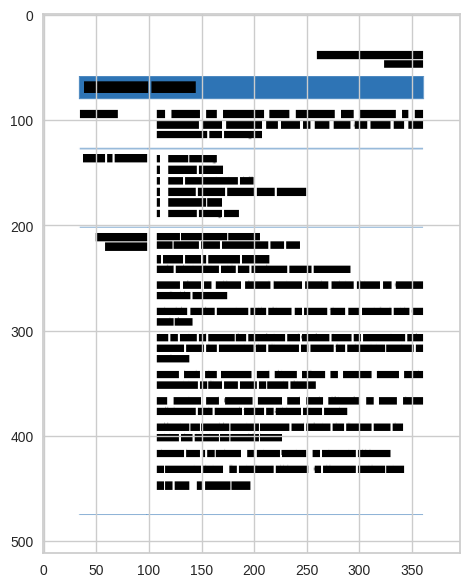

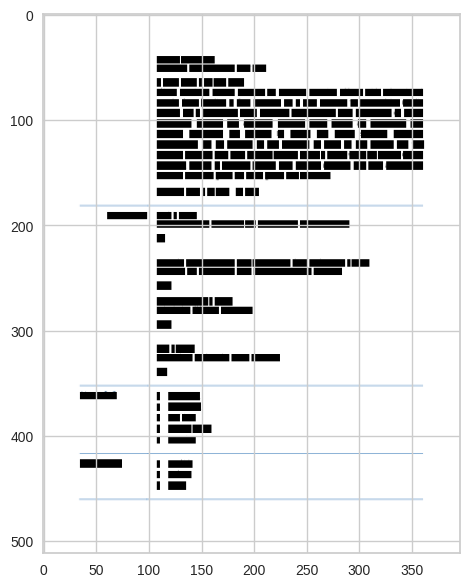

In [ ]:
show_img(imgs)

In [ ]:
model = load_cols_model('../model/best_model.pth')
pdf_text = pdf_to_text(file, model)
pdf_text

DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
/home/hamza/anaconda3/envs/dreamai_pdf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hamza/anaconda3/envs/dreamai_pdf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['DIKONDAWAR DEEKSHA To enhance my professional OBJECTIVE organization which recognizes responsibilities and challenges.',
 'SKILLS & ABILITIES Team Building   Problem Solving  ',
 'Best Communication Skill   Positive Attitude towards every  ',
 'Leadership Skill   Decision Making Skill   CLIENT RELATIONSHIP MANAGER PROFESSIONAL MAD WORKS INDIA ADVERTISING EXPERIENCE',
 '4 March 2021 - Currently Working Build relationships with key employees',
 'Create plans to address clients’ profitable processes.',
 'Schedule regular meetings with work flow. Act as point of contact for complaints creative team for correcting the products.',
 'Ensure both the company and competition to find new ways to',
 'Set services and revenue targets Collaborate with internal teams',
 'Following up monthly retainer payment raising the invoice on monthly bases.',
 'CLIENTS LIST – 1) CELEKT 2) RAMKY',
 '4) ROCKSTAR JEANS 5) MANJEERA 7) E- RICE 8) KAVURI HILLS',
 'CLIENT SERVICING FLIPSIDE ADVERTISING PVT LTD 2 Jun

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()